In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import cv2
import os
import glob
import matplotlib.pyplot as plt
import random

print("Libraries imported.")

Libraries imported.


In [ ]:
print("\n--- Step 1: Unzipping Dataset from Google Drive ---")

# --- USER: VERIFY THIS PATH ---
DRIVE_ZIP_PATH = '/content/drive/My Drive/DeepFakeDataset/140k-real-and-fake-faces.zip'
LOCAL_DATA_PATH = '/content/dataset'

if not os.path.exists(os.path.join(LOCAL_DATA_PATH, 'real_vs_fake')):
    print("Unzipping... this may take a minute.")
    !rm -rf "{LOCAL_DATA_PATH}"
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)
    !unzip -q "{DRIVE_ZIP_PATH}" -d "{LOCAL_DATA_PATH}"
else:
    print("Dataset already unzipped.")

print("✅ Data ready for prediction.\n")


--- Step 1: Unzipping Dataset from Google Drive ---
Unzipping... this may take a minute.
✅ Data ready for prediction.



In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

print("SimpleCNN model class defined.")

SimpleCNN model class defined.


In [ ]:
print("\n--- Step 2: Loading Trained Model Weights ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# --- USER: VERIFY THIS PATH ---
MODEL_PATH = '/content/drive/My Drive/DeepFakeDataset/Models/backup/simple_cnn_best_model.pth'

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print(f"✅ Model loaded from {MODEL_PATH} onto the {str(device).upper()} device.\n")


--- Step 2: Loading Trained Model Weights ---
✅ Model loaded from /content/drive/My Drive/DeepFakeDataset/Models/simple_cnn_best_model.pth onto the CUDA device.



In [ ]:
print("--- Step 3: Preparing Prediction Function ---")
im_size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Label mapping (0=FAKE, 1=REAL) is consistent with training
class_names = ['FAKE', 'REAL']

def predict_single_image(image_path):
    """Function to predict a single image and return the predicted class name."""
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    preprocessed_image = data_transforms(rgb_image)
    batch_tensor = preprocessed_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(batch_tensor)
        _, prediction_index = torch.max(output, 1)

    return class_names[prediction_index.item()]

print("✅ Prediction function is ready.\n")

--- Step 3: Preparing Prediction Function ---
✅ Prediction function is ready.



--- Step 4: Running Batch Prediction on the Reliable Validation Set ---
--- Testing 10 FAKE images (plotting the first one) ---


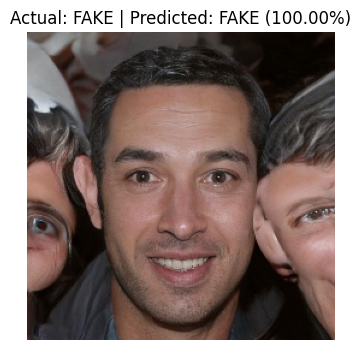

Image: W99BFKAVK5.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: B021FJ2O6G.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: AN5B2RN8ML.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: 5EX3NGC72P.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: FSPJB1LXMX.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: ONENL2FLP9.jpg       | Actual: FAKE  | Predicted: REAL  | Correct: False
Image: M5RNY4TTFC.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: DSY16YC4ST.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: 9KBFOGNXIP.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True
Image: C2ENN1KQWP.jpg       | Actual: FAKE  | Predicted: FAKE  | Correct: True

--- Testing 10 REAL images (plotting the first one) ---


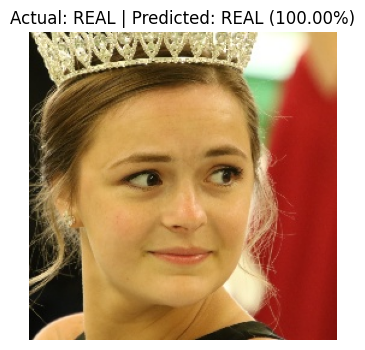

Image: 19853.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 16251.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 55592.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 12696.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 66410.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 51458.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 04764.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 01365.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 22394.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True
Image: 08403.jpg            | Actual: REAL  | Predicted: REAL  | Correct: True

-------------------------------------------
BATCH ACCURACY: 95.00% (19/20 correct)
-------------------------------------------


In [ ]:
# Cell 7: Run Batch Prediction on the Validation Set with Corrected Image Plots

# --- NEW: A modified prediction function that takes the actual label as an argument ---
def predict_and_display_image(image_path, actual_label, plot=False):
    """
    Predicts a single image. If plot=True, it also displays the image with its labels.
    Returns the predicted class name ('REAL' or 'FAKE').
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    preprocessed_image = data_transforms(rgb_image)
    batch_tensor = preprocessed_image.unsqueeze(0).to(device)

    # Make a prediction
    with torch.no_grad():
        output = model(batch_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, prediction_index = torch.max(probabilities, 1)

    prediction_class = class_names[prediction_index.item()]

    # If plotting is requested, display the image and the result
    if plot:
        prediction_confidence = confidence.item() * 100

        plt.figure(figsize=(4, 4)) # Create a figure for the image
        plt.imshow(rgb_image)
        # Use the passed-in actual_label for the title
        plt.title(f"Actual: {actual_label} | Predicted: {prediction_class} ({prediction_confidence:.2f}%)")
        plt.axis('off')
        plt.show()

    return prediction_class

# --- Main Prediction Logic ---
print("--- Step 4: Running Batch Prediction on the Reliable Validation Set ---")

VALID_DIR = '/content/dataset/real_vs_fake/real-vs-fake/valid'
fake_images_path = os.path.join(VALID_DIR, 'fake', '*.jpg')
real_images_path = os.path.join(VALID_DIR, 'real', '*.jpg')

fake_images = glob.glob(fake_images_path)
real_images = glob.glob(real_images_path)

total_correct = 0
total_images = 0

# Test 10 random FAKE images
print("--- Testing 10 FAKE images (plotting the first one) ---")
if fake_images:
    sample_size = min(10, len(fake_images))
    total_images += sample_size
    actual = "FAKE" # We know all images in this loop are FAKE
    for i, img_path in enumerate(random.sample(fake_images, sample_size)):
        # Pass the correct actual_label to the function for plotting
        prediction = predict_and_display_image(img_path, actual_label=actual, plot=(i == 0))
        is_correct = (prediction == actual)
        if is_correct:
            total_correct += 1
        print(f"Image: {os.path.basename(img_path):<20} | Actual: {actual:<5} | Predicted: {prediction:<5} | Correct: {is_correct}")
else:
    print("Could not find FAKE validation images.")


# Test 10 random REAL images
print("\n--- Testing 10 REAL images (plotting the first one) ---")
if real_images:
    sample_size = min(10, len(real_images))
    total_images += sample_size
    actual = "REAL" # We know all images in this loop are REAL
    for i, img_path in enumerate(random.sample(real_images, sample_size)):
        # Pass the correct actual_label to the function for plotting
        prediction = predict_and_display_image(img_path, actual_label=actual, plot=(i == 0))
        is_correct = (prediction == actual)
        if is_correct:
            total_correct += 1
        print(f"Image: {os.path.basename(img_path):<20} | Actual: {actual:<5} | Predicted: {prediction:<5} | Correct: {is_correct}")
else:
    print("Could not find REAL validation images.")

# --- Final Accuracy Calculation for this Batch ---
if total_images > 0:
    batch_accuracy = (total_correct / total_images) * 100
    print("\n-------------------------------------------")
    print(f"BATCH ACCURACY: {batch_accuracy:.2f}% ({total_correct}/{total_images} correct)")
    print("-------------------------------------------")

In [ ]:
import os

# --- 1. SET THE PATH TO YOUR UNZIPPED FOLDER ---
INSPECT_PATH = '/content/dataset'

# --- 2. WALK THROUGH THE DIRECTORY AND PRINT THE STRUCTURE ---
print(f"--- Folder Structure for {INSPECT_PATH} ---")

for root, dirs, files in os.walk(INSPECT_PATH):
    # Go one level deeper to show the 'real' and 'fake' folders
    if root.count(os.sep) - INSPECT_PATH.count(os.sep) > 4:
        continue

    # Calculate the level for indentation
    level = root.replace(INSPECT_PATH, '').count(os.sep)
    indent = ' ' * 4 * (level)

    # Print the current folder name
    print(f'{indent}└── {os.path.basename(root)}/')

print("\n--- End of Structure ---")

--- Folder Structure for /content/dataset ---
└── dataset/
    └── real_vs_fake/
        └── real-vs-fake/
            └── test/
                └── fake/
                └── real/
            └── train/
                └── fake/
                └── real/
            └── valid/
                └── fake/
                └── real/

--- End of Structure ---
